In [1368]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
import plotly.express as px # interactive plots

# Display all columns
pd.set_option('display.max_columns', None)

We will use this file to clean first clean the CSV file before applying some analysis. First, let's load the data.

In [1369]:
# Load the data
# Define file path
DATA_PATH = "../data/raw/DataScience_jobs.csv"

try:
    df = pd.read_csv(DATA_PATH, index_col=0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: File not found.")

# Preview
df.head()


Data loaded successfully.


,roles,companies,locations,experience,skills
0,Data Scientist,Ltimindtree,"Hybrid - Hyderabad, Chennai, Bengaluru",8-13 Yrs,"Data Science, Gen ai, Python, Data, Science, G..."
1,Urgent Hiring For FullStack-Data Scientist-Imm...,Genpact,"Hybrid - Gurugram, Bengaluru",7-12 Yrs,"Natural Language Processing, Machine Learning ..."
2,Sr. Data Scientist,NaN,NaN,NaN,NaN
3,Artificial Intelligence Developer,NaN,NaN,NaN,NaN
4,Data Science Manager,NaN,NaN,NaN,NaN


In [1370]:
# check column names and shape
print(f"Columns: {df.columns.tolist()}")
print(f"Shape: {df.shape}")


Columns: ['roles', 'companies', 'locations', 'experience', 'skills']
Shape: (1009, 5)


## Remove Rows with Missing Information
Now, we want to remove any rows that have missing values in any columns.

In [1371]:
# get rid of rows with missing values
df.isna().sum()
df = df.dropna()


In [1372]:
df.isna().sum()

roles         0
companies     0
locations     0
experience    0
skills        0
dtype: int64

In [1373]:
# See how many rows are left
df.shape

(981, 5)

## Standardize Strings via Lowercase

Note that this dataset has many columns which store non-numerical data, such as company names and locations. We will standardize these columns so that all characters are lowercase. 

In [1374]:
# let's lower case all strings in all columns
df = df.apply(lambda x: x.astype(str).str.lower())
df.head()

,roles,companies,locations,experience,skills
0,data scientist,ltimindtree,"hybrid - hyderabad, chennai, bengaluru",8-13 yrs,"data science, gen ai, python, data, science, g..."
1,urgent hiring for fullstack-data scientist-imm...,genpact,"hybrid - gurugram, bengaluru",7-12 yrs,"natural language processing, machine learning ..."
7,data scientist,wipro,bengaluru,2-7 yrs,"time series analysis, python, machine learning..."
8,rbl bank | hiring for data scientist - airoli,rbl finserve,mumbai (all areas),4-8 yrs,"data science, python, insights, machine learni..."
9,data scientist,o9 solutions,bengaluru,2-4 yrs,"supply chain, coding, project management, busi..."


## Remove Duplicates

Now that the strings are standardized, it is safe to check for duplicate posts that have identical information in all of their feature columns. This is often the case when hiring managers repost the same job position.

In [1375]:
# check for any duplicates
# get a series of booleans (T if a duplicate, F if unique)
df.duplicated(subset=["roles","companies","locations","experience","skills"])
total_duplicates = df.duplicated(subset=["roles","companies","locations","experience","skills"]).sum()
print(f"{total_duplicates} duplicates")

df.drop_duplicates(keep="first",inplace=True)
df.shape

23 duplicates


(958, 5)

## Cleaning Up: Locations, Skills, Experience

Each location column may have multiple locations listed, same as the skills column. We want to change these entries so that each row, in its "locations" column, contains a list of strings, each string the name of a location available for that job post. Similarly in the "skills" column, each job post will contain a list of strings, each of which is a desired skill. 

We will also add a new column that contains the total number of skills listed in a given job post. This could perhaps give us an additional numerical column to work with when we get to analysis.

Each row has an "experience" column that gives a range, in years, for the desired experience level required for a given job. From that column, we will create two new features to hold each the minimum and maximum experience desired in years.

In [1376]:
# some entries have multiple locations and/or skills
# so we will split these long strings into a list
df.locations = [location.split(",") for location in df.locations]
df.skills = [skill.split(",") for skill in df.skills]

In [1377]:
# let's check what the df looks like now
df.locations.tolist()[0:4]

[['hybrid - hyderabad', ' chennai', ' bengaluru'],
 ['hybrid - gurugram', ' bengaluru'],
 ['bengaluru'],
 ['mumbai (all areas)']]

In [1378]:
# remove white spaces
df['locations'] = df['locations'].apply(lambda locs: [loc.strip() for loc in locs])
print(df['locations'].tolist()[0:4])

df['skills'] = df['skills'].apply(lambda x: [skills.strip() for skills in x])
print(df['skills'].tolist()[0:2])

[['hybrid - hyderabad', 'chennai', 'bengaluru'], ['hybrid - gurugram', 'bengaluru'], ['bengaluru'], ['mumbai (all areas)']]
[['data science', 'gen ai', 'python', 'data', 'science', 'gen', 'artificial intelligence'], ['natural language processing', 'machine learning algorithms', 'object oriented programming', 'large language models', 'python', 'oops programming', 'ml algorithms', 'deep learning']]


In [1379]:
# now I want to add a column that counts total number of skills listed
df['total_skills'] = df['skills'].apply(lambda x: len(x) if isinstance(x, list) else str(x))
df.head()

,roles,companies,locations,experience,skills,total_skills
0,data scientist,ltimindtree,"[hybrid - hyderabad, chennai, bengaluru]",8-13 yrs,"[data science, gen ai, python, data, science, ...",7
1,urgent hiring for fullstack-data scientist-imm...,genpact,"[hybrid - gurugram, bengaluru]",7-12 yrs,"[natural language processing, machine learning...",8
7,data scientist,wipro,[bengaluru],2-7 yrs,"[time series analysis, python, machine learnin...",8
8,rbl bank | hiring for data scientist - airoli,rbl finserve,[mumbai (all areas)],4-8 yrs,"[data science, python, insights, machine learn...",8
9,data scientist,o9 solutions,[bengaluru],2-4 yrs,"[supply chain, coding, project management, bus...",8


In [1380]:
# let's standardize the experience
# get rid of ' yrs'

df['experience'].tolist()[0:2]

['8-13 yrs', '7-12 yrs']

In [1381]:
# remove ' yrs'
df['experience'] = df['experience'].apply(lambda x: x.replace(" yrs",""))
# change experience to a list with [int, int]
# remove '-'
df['experience'] = df['experience'].apply(lambda x: x.split("-"))
df['experience'] = df['experience'].apply(lambda x: [int(num) for num in x])
df['experience']


0       [8, 13]
1       [7, 12]
7        [2, 7]
8        [4, 8]
9        [2, 4]
         ...   
1004     [2, 3]
1005     [3, 7]
1006    [4, 10]
1007     [2, 3]
1008     [4, 8]
Name: experience, Length: 958, dtype: object

## Insights on Experience Levles

We can make a few plots to see what experience ranges are most in demand. We will do this in three ways.

1. We will make a bar plot where each bar represents a unique experience range in years of the form [minimum, maximum].
2. Next, we will repeat the exercise but this time isolating only the minimum or maximum exerience levels. We can also produce histograms to hold the same information, which are perhaps easier to interpret visually.

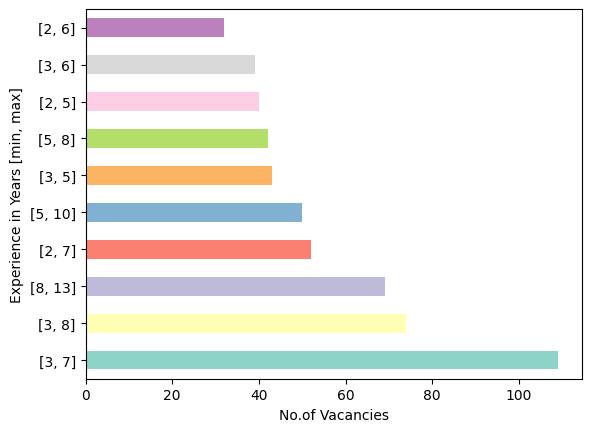

In [1382]:
# link of differnt collor pallets: https://matplotlib.org/stable/users/explain/colors/colormaps.html
colors = plt.cm.Set3.colors[:15]  # You can try 'Accent', 'tab10', or 'Dark2' for variety.

# make a bar plot showing desired experience
exp_count = df['experience'].value_counts()[:10]
exp_count.plot.barh(color=colors)
plt.xlabel("No.of Vacancies")
plt.ylabel("Experience in Years [min, max]")
plt.show()

## Observations: 
- There are the most openings in the categroy that accepts people with experience up to mid/senior level (but also down to associate level at ~3 years)
- Most jobs with want at least 2-3 years of experience.
- Most jobs want at most 5-7 years of experince

In [1383]:
# create a new feature that holds only minimum/maximum desired experience

# let's find cases where the experience column doesn't hold a list of 2 ints
filtered_df = df[df['experience'].apply(lambda x: len(x) != 2)]
filtered_df.shape
filtered_df

,roles,companies,locations,experience,skills,total_skills
310,data analyst / data scientist / data engineer ...,rudder analytics,[remote],[0],"[data analytics, business intelligence, data e...",8


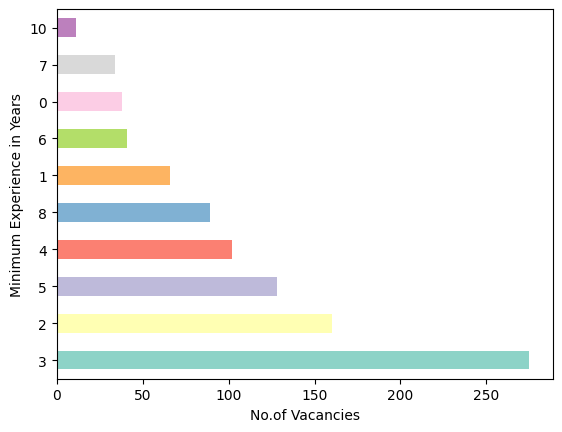

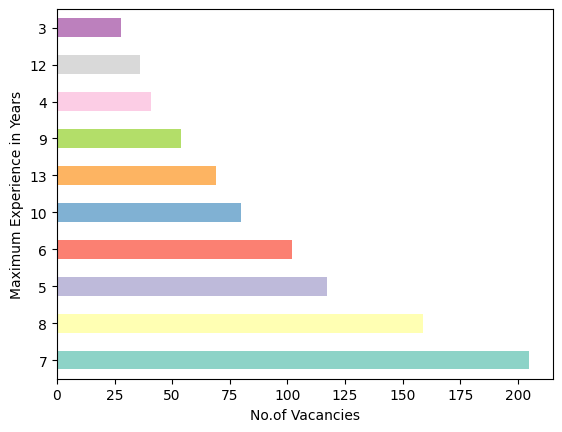

In [1384]:
# since it's only one row, we'll just drop this from the list
condition = df['experience'].apply(lambda x: len(x) != 2)
df = df[~condition]
df.shape

# add columns to hold min/max experience
min_exp = []
max_exp = []

for row in df.itertuples():
    min_exp.append(int(row.experience[0]))
    max_exp.append(int(row.experience[1]))

df['min_exp'] = min_exp
df['max_exp'] = max_exp

# make another bar plot showing minimum and max
min_exp_count = df['min_exp'].value_counts()[:10]
min_exp_count.plot.barh(color=colors)
plt.xlabel("No.of Vacancies")
plt.ylabel("Minimum Experience in Years")
plt.show()

max_exp_count = df['max_exp'].value_counts()[:10]
max_exp_count.plot.barh(color=colors)
plt.xlabel("No.of Vacancies")
plt.ylabel("Maximum Experience in Years")
plt.show()

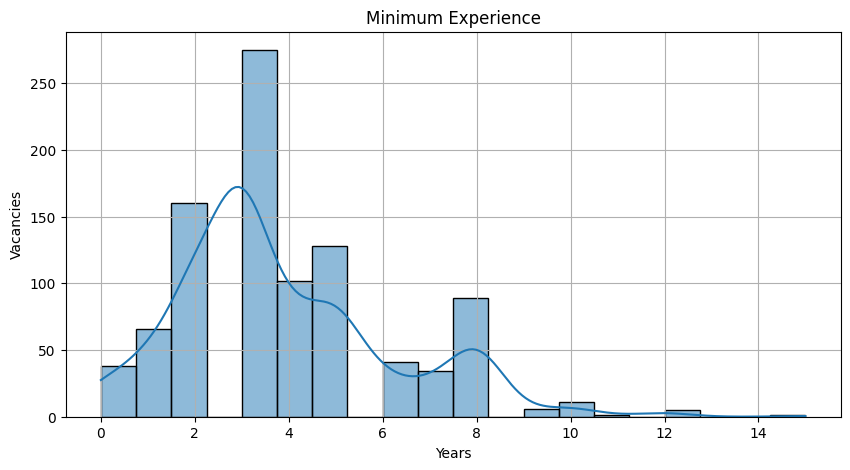

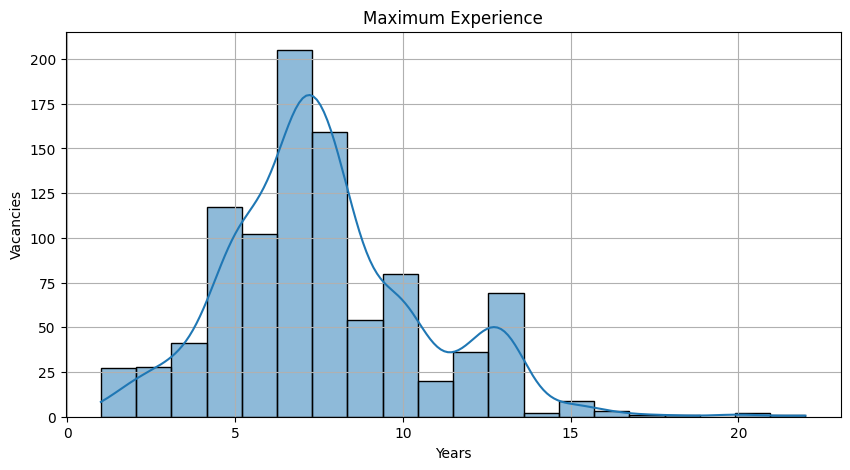

In [1385]:
# plot a distribution of min/max years

plt.figure(figsize=(10, 5))
sns.histplot(df['min_exp'], bins=20, kde=True)
plt.title("Minimum Experience")
plt.xlabel("Years")
plt.ylabel("Vacancies")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['max_exp'], bins=20, kde=True)
plt.title("Maximum Experience")
plt.xlabel("Years")
plt.ylabel("Vacancies")
plt.grid(True)
plt.show()


## Insights on Companies via Bar Plots

We can also produce bar plots to see which companies had the most jobs posted when we scraped the data. 

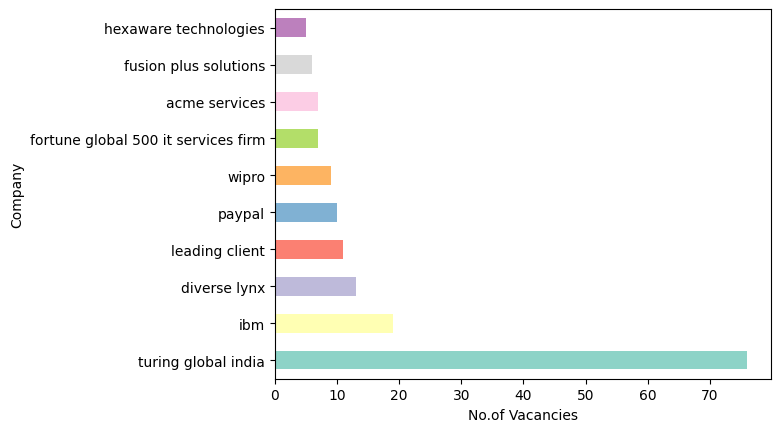

In [1386]:
# make a bar plot showing companies
comp_count = df['companies'].value_counts()[:10]
comp_count.plot.barh(color=colors)
plt.xlabel("No.of Vacancies")
plt.ylabel("Company")
plt.show()

## Follow-Up observations:
- Most hiring managers want 2-3 years minimum experience (agrees with bar plot that shows experience as a range).
- Moost hiring managers want at most 7-8 years of experience (agrees with bar plot that shows experience as a range).
- Turning Global India dominates all other companies in number of posted jop openings.

## Insights on Skills

Now we will look into the skills most frequently listed by hiring managers. Let's start by producing a bar plot that shows skills along the x-axis, and the number of times they were listed on the y-axis.

In [1387]:
# now switch gears to skills section
# goal is to produce a pie chart with most desired skills (top 10)
# slice size indicates frequency

# at this point, each row has a ['string'] in its skills column already .split() 
# but now we want to .explode() so that each entry gets put into a row
skills_data = df['skills'].explode()
print("skills_data.head(): \n", skills_data.head())
print("skills_data.shape: ", skills_data.shape)

# let's get the top most frequent skills
top_skills = skills_data.value_counts().head(15)
bot_skills = skills_data.value_counts().tail(15)
print("top skills: \n", top_skills)




skills_data.head(): 
 0    data science
0          gen ai
0          python
0            data
0         science
Name: skills, dtype: object
skills_data.shape:  (7365,)
top skills: 
 skills
machine learning               566
python                         324
data science                   290
data analysis                  207
sql                            205
analytical                     168
natural language processing    161
computer science               134
data mining                    120
data                           120
artificial intelligence        119
deep learning                  118
analytics                      104
gcp                             78
machine                         73
Name: count, dtype: int64


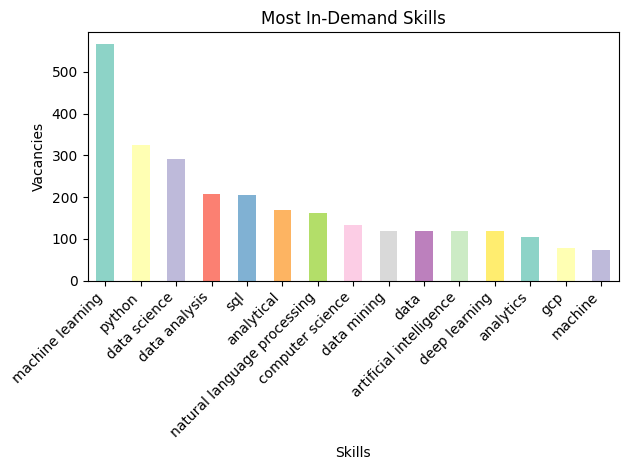

In [1388]:
# bar plot
top_skills.plot(kind="bar", color=colors)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Vacancies")
plt.xlabel("Skills")
plt.title("Most In-Demand Skills")
plt.tight_layout()
plt.show()


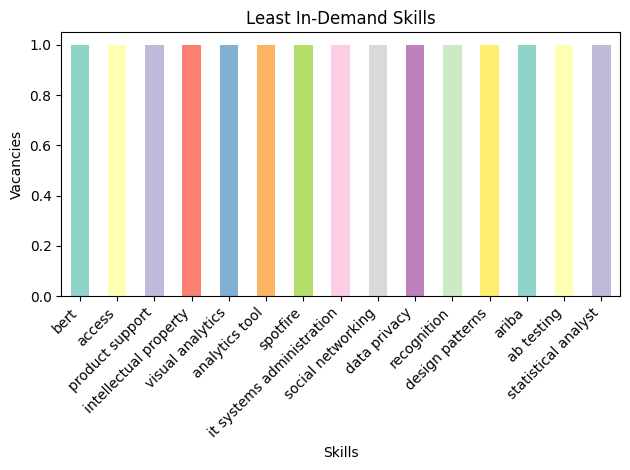

In [1389]:
# bar plot for least in-demand
bot_skills.plot(kind="bar", color=colors)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Vacancies")
plt.xlabel("Skills")
plt.title("Least In-Demand Skills")
plt.tight_layout()
plt.show()

## Further Cleanup Required
Some skills that are phrases rather than words are split into two elements, such as 'data science' -> 'data','science'. Other times, there are abbreviations that are falsely identified as a new skill. For example, 'machine learning' should be regarded as equivalent to 'ml', and 'natural language processing' should be regarded as equivalent to 'npl'. We'll do our best to make this list cohesive by combining duplicates above

In [1390]:
# conver skills column into a new df
skl_df = pd.DataFrame(df.skills.apply(pd.Series).stack().value_counts()).reset_index()

# explanations for the code above:
# df.skills : returns the last column of the df as a (957,) vector where each row contains ['str']
# .apply(pd.Series) creates a table with (957,n) where n = maximum length of ['str'] in column 'skills'
# .stack() gets us to a list of (~7000,) where ~7000 is the number of unique skills that appear in all lists
# then we use value_counts to see which keywords appear most frequently

skl_df.columns=["skills","count"]
skl_df.head(20)

# now I want to add a column that counts total number of skills listed
df['total_skills'] = df['skills'].apply(lambda x: len(x) if isinstance(x, list) else str(x))
df.head()

,roles,companies,locations,experience,skills,total_skills,min_exp,max_exp
0,data scientist,ltimindtree,"[hybrid - hyderabad, chennai, bengaluru]","[8, 13]","[data science, gen ai, python, data, science, ...",7,8,13
1,urgent hiring for fullstack-data scientist-imm...,genpact,"[hybrid - gurugram, bengaluru]","[7, 12]","[natural language processing, machine learning...",8,7,12
7,data scientist,wipro,[bengaluru],"[2, 7]","[time series analysis, python, machine learnin...",8,2,7
8,rbl bank | hiring for data scientist - airoli,rbl finserve,[mumbai (all areas)],"[4, 8]","[data science, python, insights, machine learn...",8,4,8
9,data scientist,o9 solutions,[bengaluru],"[2, 4]","[supply chain, coding, project management, bus...",8,2,4


This next cell uses regular expressions to rectify some of the example cases given above in which one unique skill can be represented with multiple unique skills. This was my first time using regular expressions, and so I tried this exercise with the 'regex' option set to True and False and tried to make sense out of the differences.

In [1391]:
# lets first find the top skills for Data science in general
# Extra material for regular expression: https://regexlearn.com/
datascience={}

# let's say any words that contain 'stat' should be lumped into the skill 'statistics'
datascience['statistics']=skl_df["count"][skl_df['skills'].str.contains('stat', regex=True)].sum()
datascience['machine_learning']=skl_df["count"][skl_df['skills'].str.contains('machine |^ml', regex=True)].sum()
datascience['data_analysis']=skl_df["count"][skl_df['skills'].str.contains('data ana', regex=True)].sum()
datascience['data_mining']=skl_df["count"][skl_df['skills'].str.contains('mining', regex=True)].sum()
datascience['nlp']=skl_df["count"][skl_df['skills'].str.contains('nlp|natural', regex=True)].sum()
datascience['computer_vision']=skl_df["count"][skl_df['skills'].str.contains('computer vision', regex=True)].sum()
datascience['deep_learning']=skl_df["count"][skl_df['skills'].str.contains('deep learning', regex=True)].sum()
datascience['big_data']=skl_df["count"][skl_df['skills'].str.contains('big', regex=True)].sum()

for each in ['statistics','machine_learning','data_analysis','data_mining','nlp','computer_vision','deep_learning','big_data']:
    print(f'{each}: {datascience[each]}')

statistics: 134
machine_learning: 639
data_analysis: 283
data_mining: 141
nlp: 184
computer_vision: 63
deep_learning: 120
big_data: 35


In [1392]:
# what happens if i make regex=False?
# Extra material for regular expression: https://regexlearn.com/
datascience={}

# let's say any words that contain 'stat' should be lumped into the skill 'statistics'
datascience['statistics']=skl_df["count"][skl_df['skills'].str.contains('stat', regex=False)].sum()
datascience['machine_learning']=skl_df["count"][skl_df['skills'].str.contains('machine |^ml', regex=False)].sum()
datascience['data_analysis']=skl_df["count"][skl_df['skills'].str.contains('data ana', regex=False)].sum()
datascience['data_mining']=skl_df["count"][skl_df['skills'].str.contains('mining', regex=False)].sum()
datascience['nlp']=skl_df["count"][skl_df['skills'].str.contains('nlp|natural', regex=False)].sum()
datascience['computer_vision']=skl_df["count"][skl_df['skills'].str.contains('computer vision', regex=False)].sum()
datascience['deep_learning']=skl_df["count"][skl_df['skills'].str.contains('deep learning', regex=False)].sum()
datascience['big_data']=skl_df["count"][skl_df['skills'].str.contains('big', regex=False)].sum()

for each in ['statistics','machine_learning','data_analysis','data_mining','nlp','computer_vision','deep_learning','big_data']:
    print(f'{each}: {datascience[each]}')

statistics: 134
machine_learning: 0
data_analysis: 283
data_mining: 141
nlp: 0
computer_vision: 63
deep_learning: 120
big_data: 35


### Explanation between results with regex=True vs regex=False
As expected, the only results that change are the ones that use special regex characters. For example 'machine |^ml' searches for any strings that contain 'machine ' (the space indicates it is followed by a second word like 'learning') or ml. 
'nlp|natural' counts entries that have either 'nlp' or 'natural' contained in their string.



In [1393]:
from operator import itemgetter

# Sort the 'datascience' dictionary by its values in descending order
datascience=dict(sorted(datascience.items(), key=itemgetter(1),reverse=True))
datascience

{'data_analysis': np.int64(283),
 'data_mining': np.int64(141),
 'statistics': np.int64(134),
 'deep_learning': np.int64(120),
 'computer_vision': np.int64(63),
 'big_data': np.int64(35),
 'machine_learning': np.int64(0),
 'nlp': np.int64(0)}

## Skills Insights By Category

Now we will break skills into different categories. For example, maybe we're interested in seeing which programming languages are most in-demand. Then, we can compile a list of common languages, find out how many times each are listed, and then put this information into a bar plot. This exercise is repeated for other categories such as visualization tools and cloud software.

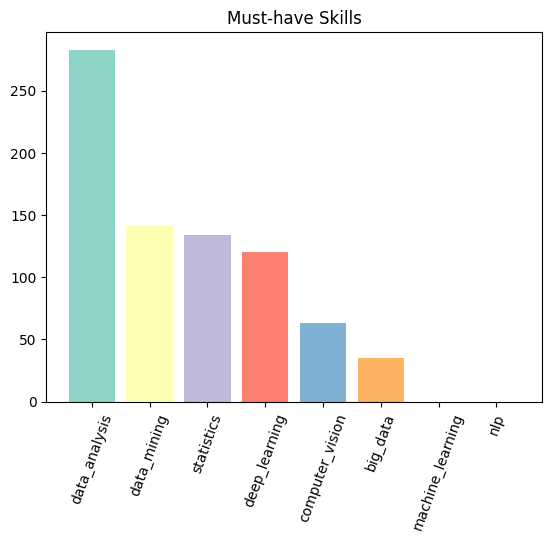

In [1394]:
# Plot the most important skills.
plt.bar(datascience.keys(),datascience.values(),color=colors)
plt.xticks(rotation=70)
plt.title("Must-have Skills")
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_53663/2937757517.py:7: SyntaxWarning: invalid escape sequence '\+'
  languages["c++"]=skl_df["count"][skl_df['skills'].str.contains('c\+', regex=True)].sum()


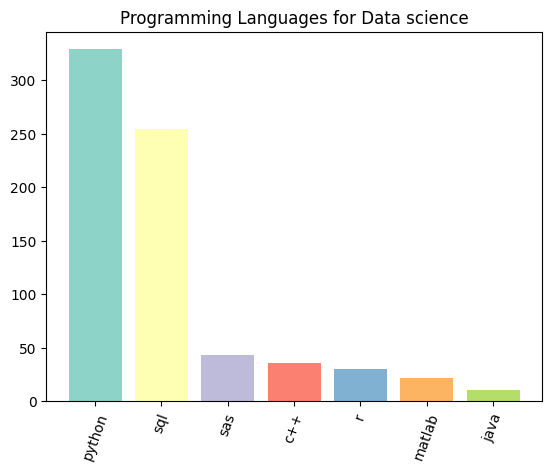

In [1395]:
# Language selection
languages={}
languages["python"]=skl_df["count"][skl_df['skills'].str.contains('python', regex=True)].sum()
languages["r"]=skl_df["count"][skl_df['skills'].str.contains('^r$', regex=True)].sum()
languages["matlab"]=skl_df["count"][skl_df['skills'].str.contains('matlab', regex=True)].sum()
languages["java"]=skl_df["count"][skl_df['skills'].str.contains('java$', regex=True)].sum()
languages["c++"]=skl_df["count"][skl_df['skills'].str.contains('c\+', regex=True)].sum()
languages["sas"]=skl_df["count"][skl_df['skills'].str.contains('sas', regex=True)].sum()

#to identify the Sql first and then seperate the nosql from the list
sql=skl_df[skl_df['skills'].str.contains('sql', regex=True)]
languages["sql"]=sql["count"][~sql['skills'].str.contains('no', regex=True)].sum()

#to sort the dictionary
languages=dict(sorted(languages.items(), key=itemgetter(1),reverse=True))

# Plot
plt.bar(languages.keys(),languages.values(),color=colors)
plt.xticks(rotation=70)
plt.title("Programming Languages for Data science")
plt.show()

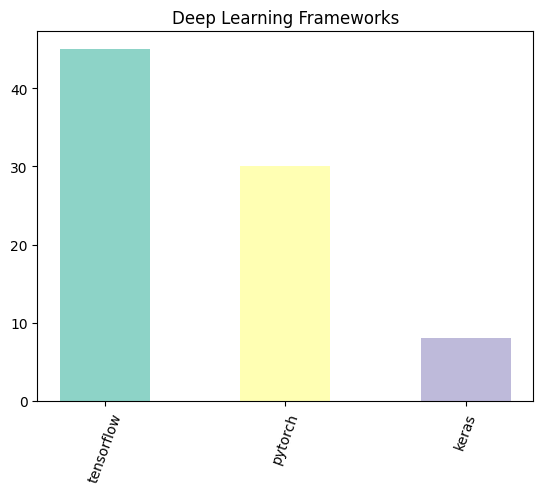

In [1396]:
# Framework selection
frameworks={}
frameworks['tensorflow']=skl_df["count"][skl_df['skills'].str.contains('tensor', regex=True)].sum()
frameworks['keras']=skl_df["count"][skl_df['skills'].str.contains('keras', regex=True)].sum()
frameworks['pytorch']=skl_df["count"][skl_df['skills'].str.contains('torch', regex=True)].sum()

# Sort
frameworks=dict(sorted(frameworks.items(), key=itemgetter(1),reverse=True))

# Plot
plt.bar(frameworks.keys(),frameworks.values(),color=colors,width=.5)
plt.xticks(rotation=70)
plt.title("Deep Learning Frameworks")
plt.show()

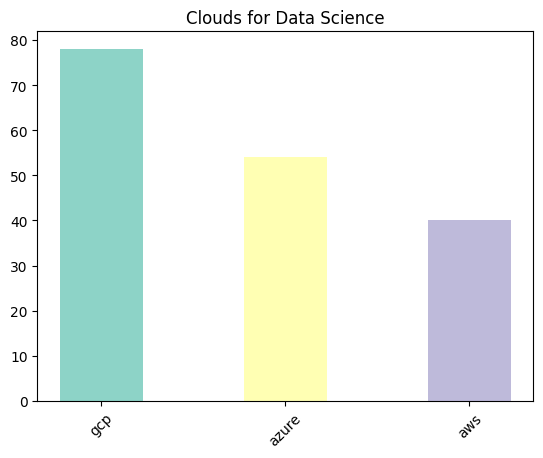

In [1397]:
#Providers selection
cloud={}
cloud['aws']=skl_df["count"][skl_df['skills'].str.contains('aws', regex=True)].sum()
cloud['azure']=skl_df["count"][skl_df['skills'].str.contains('azure', regex=True)].sum()
cloud['gcp']=skl_df["count"][skl_df['skills'].str.contains('gcp')].sum()

# Sort
cloud=dict(sorted(cloud.items(), key=itemgetter(1),reverse=True))

# Plot
plt.bar(cloud.keys(),cloud.values(),color=colors,width=.45)
plt.xticks(rotation=45)
plt.title("Clouds for Data Science")
plt.show()

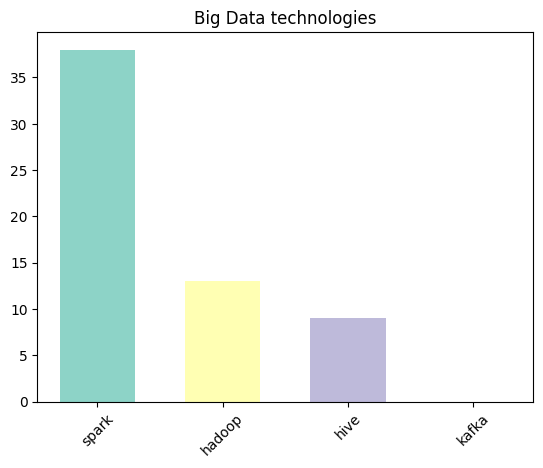

In [1398]:
# Tech Selection
bigdata={}
bigdata["spark"]=skl_df["count"][skl_df['skills'].str.contains('spark', regex=True)].sum()
bigdata["hadoop"]=skl_df["count"][skl_df['skills'].str.contains('hadoop', regex=True)].sum()
bigdata["hive"]=skl_df["count"][skl_df['skills'].str.contains('hive', regex=True)].sum()
bigdata["kafka"]=skl_df["count"][skl_df['skills'].str.contains('kafka', regex=True)].sum()

# Sort
bigdata=dict(sorted(bigdata.items(), key=itemgetter(1),reverse=True))

# Plot
plt.bar(bigdata.keys(),bigdata.values(),color=colors,width=0.6)
plt.xticks(rotation=45)
plt.title("Big Data technologies")
plt.show()

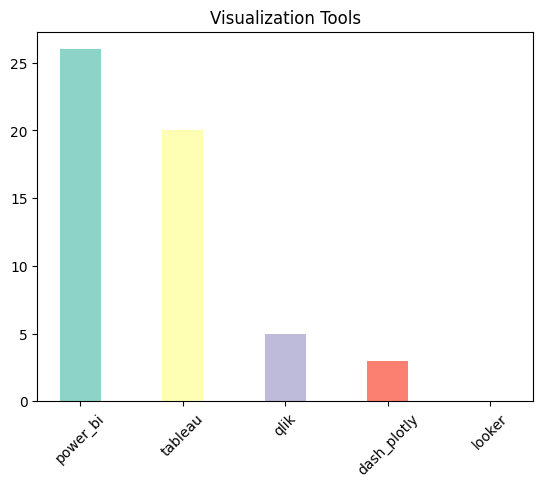

In [1399]:
# tools selection
tools={}
tools["tableau"]=skl_df["count"][skl_df['skills'].str.contains('tableau', regex=True)].sum()
tools["power_bi"]=skl_df["count"][skl_df['skills'].str.contains('power bi', regex=True)].sum()
tools["looker"] = skl_df["count"][skl_df['skills'].str.contains('looker', regex=True)].sum()
tools["qlik"] = skl_df["count"][skl_df['skills'].str.contains('qlik', regex=True)].sum()
tools["dash_plotly"] = skl_df["count"][skl_df['skills'].str.contains('plotly|dash', regex=True)].sum()

# Sort
tools=dict(sorted(tools.items(), key=itemgetter(1),reverse=True))

# Plot
plt.bar(tools.keys(),tools.values(),color=colors,width=(0.4))
plt.xticks(rotation=45)
plt.title("Visualization Tools")
plt.show()

### Clustering Exericises

Now we'll cluster the locations of the jobs using dimensionality reduction.

**Description:**

In this analysis, we aim to cluster job postings based on their **locations** by applying **dimensionality reduction** and **clustering** techniques.

**Steps:**

1. **Data Preparation:**  
   - Start with a sample DataFrame containing roles, companies, locations, experience, and skills.
   - Clean the `locations` column by removing terms in brackets, i.e. "Mumbai (all locations)" &rarr; "Mumbai'

2. **Vectorization:**  
   - Convert the cleaned location strings into numerical feature vectors using `CountVectorizer`. This is similar to one-hot encoding. Essentially, every row contains a list of booleans. This list is as long as the number of unique locations in our dataset. Each boolean shows whether that post is applicable to a given location or not.

3. **Dimensionality Reduction:**  
   - Apply **PCA** (Principal Component Analysis) to reduce the location vectors to 2 dimensions.
   - Apply **UMAP** (Uniform Manifold Approximation and Projection) for a nonlinear 2D embedding.

4. **Clustering:**  
   - Perform **KMeans clustering** on both the PCA and UMAP embeddings.

In [1400]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [1401]:
# Step 1: Clean locations (remove brackets if needed)
# Step 1: Convert location list to string
df['locations_clean'] = df['locations'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# Force locations_clean to be string
df['locations_clean'] = df['locations_clean'].astype(str)
print(f"df['locations_clean shape']: {df['locations_clean'].shape}")

# Step 2: Vectorize locations
vectorizer = CountVectorizer()
location_vectors = vectorizer.fit_transform(df['locations_clean']).toarray()


df['locations_clean shape']: (957,)


In [1402]:
## vector representation of the locations. Here problem is the vectors are high dimensional. So, let's reduce the dimensions of the vectors
location_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], shape=(957, 94))

/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


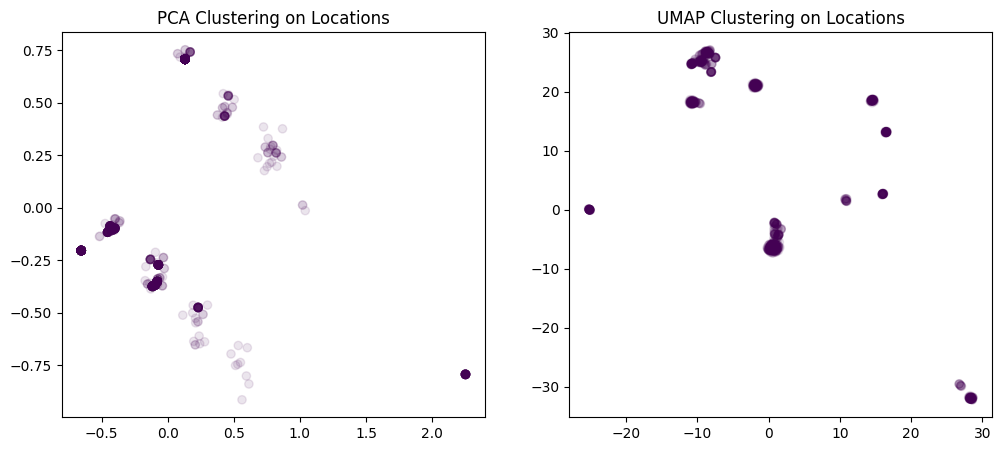

In [1403]:
# Step 3a: PCA reduction
pca = PCA(n_components=2)
location_pca = pca.fit_transform(location_vectors)

# Step 3b: UMAP reduction
reducer = umap.UMAP(n_components=2, random_state=42)
location_umap = reducer.fit_transform(location_vectors)

# Step 4: Clustering (example with KMeans)
kmeans_pca = KMeans(n_clusters=1, random_state=42).fit(location_pca)  # 1 cluster because same location
kmeans_umap = KMeans(n_clusters=1, random_state=42).fit(location_umap)

# Step 5: Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PCA plot
axs[0].scatter(location_pca[:, 0], location_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis', alpha=0.1)
axs[0].set_title('PCA Clustering on Locations')

# UMAP plot
axs[1].scatter(location_umap[:, 0], location_umap[:, 1], c=kmeans_umap.labels_, cmap='viridis', alpha=0.1)
axs[1].set_title('UMAP Clustering on Locations')

plt.show()

### now we'll cluster the jobs based on skills
**Description:**

In this analysis, we aim to cluster job postings based on their **skills** the same way as above

**Steps:**

1. **Data Preparation:**  
   - Start with a sample DataFrame containing roles, companies, skills, experience, and skills.

2. **Vectorization:**  
   - Convert the skills strings into numerical feature vectors using `CountVectorizer`.

3. **Dimensionality Reduction:**  
   - Apply **PCA** (Principal Component Analysis) to reduce the skills vectors to 2 dimensions.
   - Apply **UMAP** (Uniform Manifold Approximation and Projection) for a nonlinear 2D embedding.

4. **Clustering:**  
   - Perform **KMeans clustering** on both the PCA and UMAP embeddings.

In [1404]:
#print(df['locations_clean'].head())
"""for i, row in df.iterrows():
    loc_list = row.locations
    new_list = []
    for loc in loc_list:
        if 'hybrid' in loc:
            new_list.append('hybrid')
        else:
            new_list.append(loc)
    df.at[i,'locations'] = new_list"""

# Step 1: Clean locations (remove brackets if needed)
df['locations_clean'] = df['locations'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
print(df['locations_clean'].head())

# Force locations_clean to be string
df['locations_clean'] = df['locations_clean'].astype(str)

print(df['locations_clean'].head())
print(f"unique values: {df['locations_clean'].nunique()}")

0    hybrid - hyderabad, chennai, bengaluru
1              hybrid - gurugram, bengaluru
7                                 bengaluru
8                        mumbai (all areas)
9                                 bengaluru
Name: locations_clean, dtype: object
0    hybrid - hyderabad, chennai, bengaluru
1              hybrid - gurugram, bengaluru
7                                 bengaluru
8                        mumbai (all areas)
9                                 bengaluru
Name: locations_clean, dtype: object
unique values: 145


/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


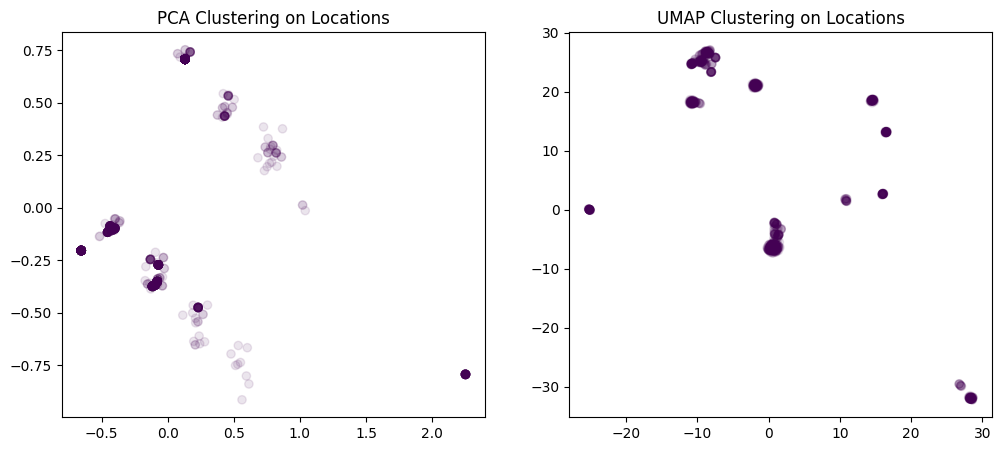

In [1405]:
# Does PCA look different with the new hybrid category? 

# Step 3a: PCA reduction
pca = PCA(n_components=2)
location_pca = pca.fit_transform(location_vectors)

# Step 3b: UMAP reduction
reducer = umap.UMAP(n_components=2, random_state=42)
location_umap = reducer.fit_transform(location_vectors)

# Step 4: Clustering (example with KMeans)
kmeans_pca = KMeans(n_clusters=1, random_state=42).fit(location_pca)  # 1 cluster because same location
kmeans_umap = KMeans(n_clusters=1, random_state=42).fit(location_umap)

# Step 5: Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PCA plot
axs[0].scatter(location_pca[:, 0], location_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis', alpha=0.1)
axs[0].set_title('PCA Clustering on Locations')

# UMAP plot
axs[1].scatter(location_umap[:, 0], location_umap[:, 1], c=kmeans_umap.labels_, cmap='viridis', alpha=0.1)
axs[1].set_title('UMAP Clustering on Locations')

plt.show()

No, these plots look almost indistinguishable from one another. 

In [1406]:
# Let's cluster by skills
df['skills_clean'] = df['skills'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# Force skills to be string
df['skills_clean'] = df['locations_clean'].astype(str)

# Vectorize locations
vectorizer = CountVectorizer()
skills_vectors = vectorizer.fit_transform(df['skills_clean']).toarray()

print(f"{df['skills_clean'].nunique()} values")

145 values


/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


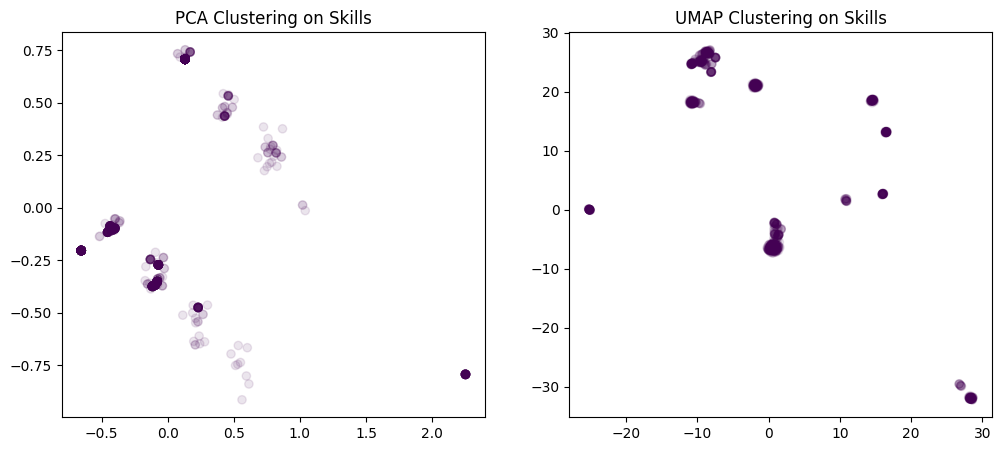

In [1407]:

# Step 3a: PCA reduction
pca = PCA(n_components=2)
skill_pca = pca.fit_transform(skills_vectors)

# Step 3b: UMAP reduction
reducer = umap.UMAP(n_components=2, random_state=42)
skills_umap = reducer.fit_transform(skills_vectors)

# Step 4: Clustering (example with KMeans)
kmeans_pca = KMeans(n_clusters=1, random_state=42).fit(skill_pca)  # 1 cluster because same skills
kmeans_umap = KMeans(n_clusters=1, random_state=42).fit(skills_umap)

# Step 5: Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PCA plot
axs[0].scatter(skill_pca[:, 0], skill_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis', alpha=0.1)
axs[0].set_title('PCA Clustering on Skills')

# UMAP plot
axs[1].scatter(skills_umap[:, 0], skills_umap[:, 1], c=kmeans_umap.labels_, cmap='viridis', alpha=0.1)
axs[1].set_title('UMAP Clustering on Skills')

plt.show()

646 values


/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


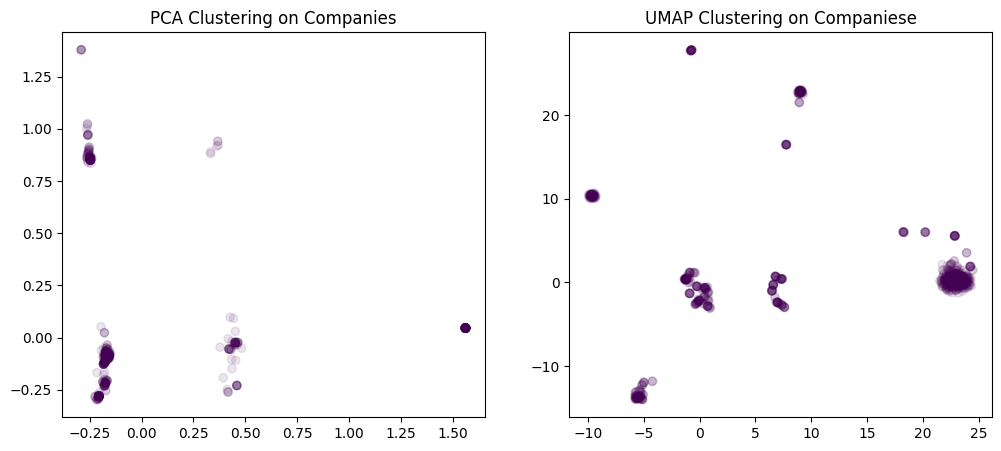

In [1408]:
# Let's cluster by companies
df['companies'] = df['companies'].astype(str)

# Vectorize 
vectorizer = CountVectorizer()
comps_vectors = vectorizer.fit_transform(df['companies']).toarray()

print(f"{df['companies'].nunique()} values")


# Step 3a: PCA reduction
pca = PCA(n_components=2)
comps_pca = pca.fit_transform(comps_vectors)

# Step 3b: UMAP reduction
reducer = umap.UMAP(n_components=2, random_state=42)
comps_umap = reducer.fit_transform(comps_vectors)

# Step 4: Clustering (example with KMeans)
kmeans_pca = KMeans(n_clusters=1, random_state=42).fit(comps_pca)  # 1 cluster because same comps
kmeans_umap = KMeans(n_clusters=1, random_state=42).fit(comps_umap)

# Step 5: Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PCA plot
axs[0].scatter(comps_pca[:, 0], comps_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis', alpha=0.1)
axs[0].set_title('PCA Clustering on Companies')

# UMAP plot
axs[1].scatter(comps_umap[:, 0], comps_umap[:, 1], c=kmeans_umap.labels_, cmap='viridis', alpha=0.1)
axs[1].set_title('UMAP Clustering on Companiese')

plt.show()

## Interpretations

The first two sets of clustering examples (location and skills) above return the same results. Why? Because we are dealing with categorical data. There are as many unique values in the 'locations_cleaned' column as there are in the 'skills' column. There is a 1 to 1 mapping happening here. How can we be more sensitive to elements in each list of locations or skills, rather than entire lists that appear in each row? 

The 'companies' column typically contains the name of one company, there is not a 1 to one mappening happening between the data points in this last plot and either plot that appears beforehand.

# Another PCA Example 

We'll do a final PCA clustering using three numerical columns: minimum experience, maximum experience, and total skills listed. We'll first plot these variables against one another in 2D to visually check if there are any strong correlations. Then, we will run a PCA clustering with 2 components using various combinations of (minimum experience, maximum experience, total skills). 


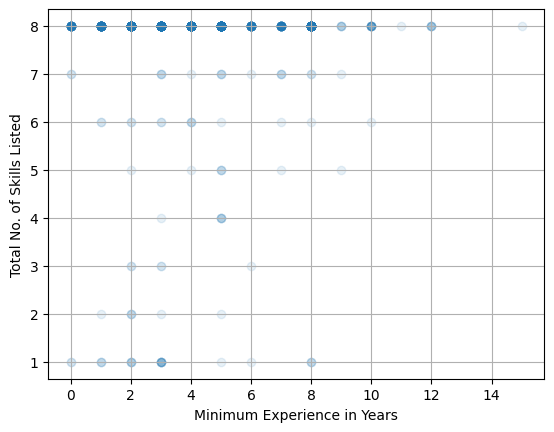

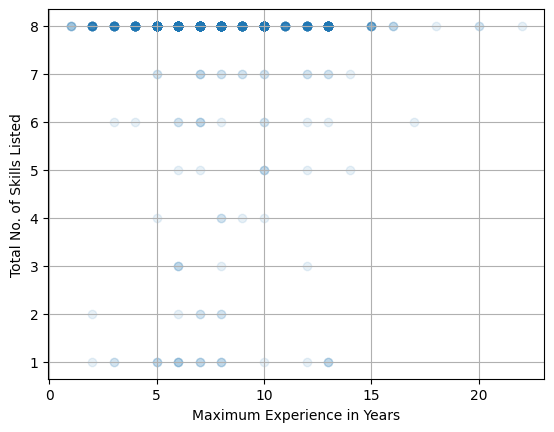

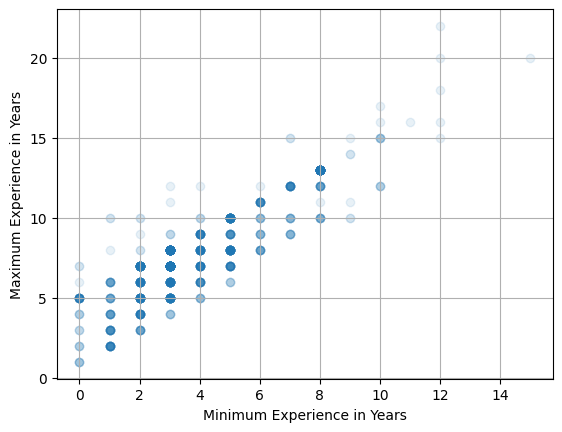

In [1409]:
# first I want to create a scatter plot where 
# x-values represent minimum desired experience level
# y-values represent no. of listed skills

x = df['min_exp']
y = df['total_skills']

scatter_points = zip(x,y)

plt.figure()
plt.xlabel("Minimum Experience in Years")
plt.ylabel("Total No. of Skills Listed")
plt.grid()
plt.scatter(x,y,alpha=0.1)

x = df['max_exp']
y = df['total_skills']

plt.figure()
plt.xlabel("Maximum Experience in Years")
plt.ylabel("Total No. of Skills Listed")
plt.grid()
plt.scatter(x,y,alpha=0.1)

x = df['min_exp']
y = df['max_exp']

plt.figure()
plt.xlabel("Minimum Experience in Years")
plt.ylabel("Maximum Experience in Years")
plt.grid()
plt.scatter(x,y,alpha=0.1)


Because these features are in a similar range, we worry about scaling the data. 

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_53663/1182802330.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(exp_skills_pca[:, 0], exp_skills_pca[:, 1], cmap='viridis', alpha=0.1)


Text(0.5, 1.0, 'PCA Clustering on Min and Max Experience')

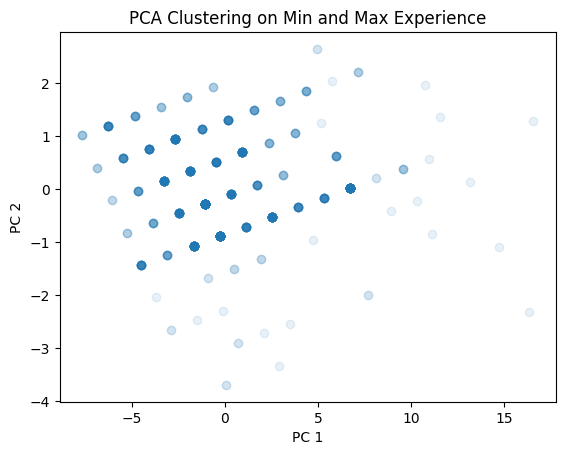

In [1410]:
pca = PCA(n_components=2)
exp_skills_pca = pca.fit_transform(df[['min_exp','max_exp']])

plt.figure()
plt.scatter(exp_skills_pca[:, 0], exp_skills_pca[:, 1], cmap='viridis', alpha=0.1)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('PCA Clustering on Min and Max Experience')

## Interpretation:

As we saw, there was strong correlation between minimum experience and maximum experience. As such, this figure appears to have PC1 drawn through the linear trend apparent in the (min exp) vs (max exp) figure. PC2 is measuring differences in the ratio of min/max years, normal to PC1. We can interpret gaps along PC2 as separating rows that have different ratios between min/max experience. We can interpret gaps along PC1 as scaling the overall work experience range. In other words, points with a higher PC1 value correspond to points that require more experience. 

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_53663/1529838280.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(exp_skills_pca[:, 0], exp_skills_pca[:, 1], cmap='viridis', alpha=0.1)


Text(0.5, 1.0, 'PCA Clustering on Min Experience and No. Skills')

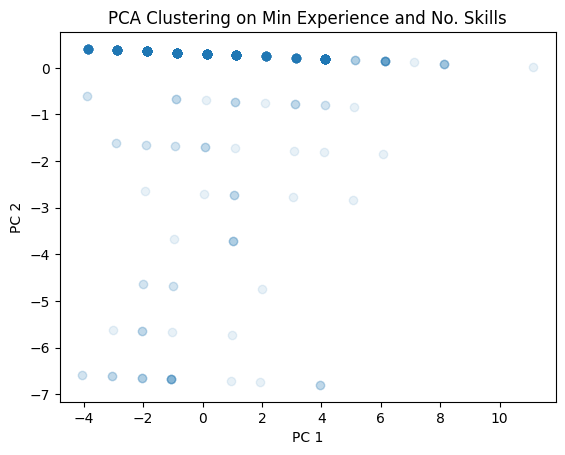

In [1411]:
pca = PCA(n_components=2)
exp_skills_pca = pca.fit_transform(df[['min_exp','total_skills']])

plt.figure()
plt.scatter(exp_skills_pca[:, 0], exp_skills_pca[:, 1], cmap='viridis', alpha=0.1)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('PCA Clustering on Min Experience and No. Skills')

## Interpretation:

As we saw, there was a little correlation between minimum experience and total number of listed skills but not very strong, as many jobs regardless of experience level listed 8 skills. As such, this figure appears to have PC1 nearly parallel to the x-axis that previously represented maximum experience, and PC2 is nearly parallel to the y-axis that previously represented no. of skills. However, PC2=0 is now set at approximately y = 8. The gaps that appear along PC2 are gaps dominated by differences in total skills. 

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_53663/3619440037.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(exp_skills_pca[:, 0], exp_skills_pca[:, 1], cmap='viridis', alpha=0.1)


Text(0.5, 1.0, 'PCA Clustering on Max Experience and No. Skills')

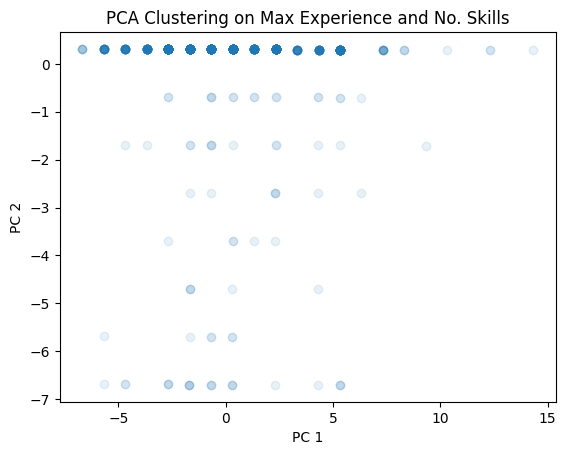

In [1412]:
pca = PCA(n_components=2)
exp_skills_pca = pca.fit_transform(df[['max_exp','total_skills']])

plt.figure()
plt.scatter(exp_skills_pca[:, 0], exp_skills_pca[:, 1], cmap='viridis', alpha=0.1)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('PCA Clustering on Max Experience and No. Skills')

## Interpretation:

As we saw, there was very little correlation between maxnimum experience and total number of listed skills, as many jobs regardless of experience level listed 8 skills. As such, this figure appears to have PC1 nearly parallel to the x-axis that previously represented minimum experience, and PC2 is nearly parallel to the y-axis that previously represented no. of skills. However, PC2=0 is now set at approximately y = 8. 

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_53663/2655408336.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(exp_skills_pca[:, 0], exp_skills_pca[:, 1], cmap='viridis', alpha=0.1)


Text(0.5, 1.0, 'PCA Clustering on Experience Range and No. Skills')

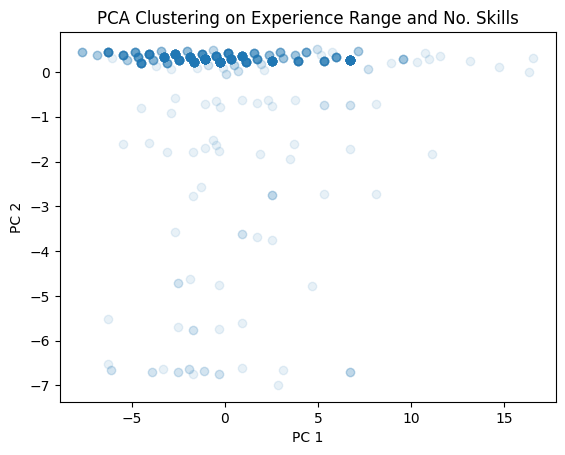

In [1413]:
pca = PCA(n_components=2)
exp_skills_pca = pca.fit_transform(df[['min_exp','max_exp','total_skills']])

plt.figure()
plt.scatter(exp_skills_pca[:, 0], exp_skills_pca[:, 1], cmap='viridis', alpha=0.1)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('PCA Clustering on Experience Range and No. Skills')

## Interpretation:

As we saw, there was a little correlation between minimum experience and total number of listed skills but not very strong, as many jobs regardless of experience level listed 8 skills. As such, this figure appears to have PC1 nearly parallel to the x-axis that previously represented maximum experience, and PC2 is nearly parallel to the y-axis that previously represented no. of skills. However, PC2=0 is now set at approximately y = 8. The gaps that appear along PC2 are gaps dominated by differences in total skills. 